# Pre requisites

install samtools, bedtools, bwa, fastqc, ...

set up python environment with pipenv


# Read Preprocessing and Alignment 

### check fastq quality
fastqc aln1.fastq.gz aln2.fastq.gz

### trim adapters and primers with cutadapt

cutadapt \
  -a AGACTCGGCAGCATCTCCA \
  -A GCGATCGTCACTGTTCTCCA \
  -g ^TTGCCAGTTAACGTCTTCCTTCTCTCTCTG \
  -G ^GAGAAAAGGTGGGCCTGAGGTTCAGAGCCA \
  -g ^CCCTTGTCTCTGTGTTCTTGTCCCCCCCA \
  -G ^CCCCACCAGACCATGAGAGGCCCTGCGGCC \
  -g ^TGATCTGTCCCTCACAGCAGGGTCTTCTCT \
  -G ^TGACCTAAAGCCACCTCCTTA \
  -g ^CACACTGACGTGCCTCTCCCTCCCTCCA \
  -G ^CCGTATCTCCCTTCCCTGATTA \
  -q 20 \
  -m 50 \
  -o trimmed_aln1.fastq.gz \
  -p trimmed_aln2.fastq.gz \
  aln1.fastq.gz aln2.fastq.gz

check with they are gone with:
zcat trimmed_aln1.fastq.gz | grep -c 'CACACTGACGTGCCTCTCCCTCCCTCCA'
zcat trimmed_aln2.fastq.gz | grep -c 'CCGTATCTCCCTTCCCTGATTA'

### index the genome for BWA
~/Downloads/bwa/bwa index hg19.fa
~/Downloads/bwa/bwa mem -t 8 hg19.fa ../sequenceFile/trimmed_aln1.fastq.gz ../sequenceFile/trimmed_aln2.fastq.gz > ../sequenceFile/my_aln.sam

### Convert SAM to BAM
samtools view -Sb my_aln.sam > my_aln.bam

### Sort the BAM file by read name or position
samtools sort my_aln.bam -o my_aln_sorted.bam

### Index the BAM file
samtools index my_aln_sorted.bam


# EDA 

Create a python environment with the required libraries.

```pipenv install -R requirements.tx```

```pipenv shell```



In [39]:
# import here all the libraries I will be using

import pandas as pd
import pysam
import pybedtools as pb
import matplotlib.pyplot as plt
import numpy as np
import sh
import scipy

# Commands I will use later
samtools_cmd = sh.Command("samtools")
less_cmd = sh.Command("less")
head_cmd = sh.Command("head")

I will first check for the bam file quality, and filter bad reads if needed.

In [2]:
samtools_cmd("stats","../sequenceFile/my_aln_sorted.bam",_out="../output/my_align_sorted_stats.txt")

''

the stats show some unmapped reads, some bad quality reads, 9% of not properly paired reads

In [3]:

samtools_cmd("view","-b","-q","30","-f","2","-F","4","../sequenceFile/my_aln_sorted.bam", _out= "../sequenceFile/my_aln_sorted.filtered.bam")
samtools_cmd("stats","../sequenceFile/my_aln_sorted.filtered.bam",_out="../output/my_align_sorted.filtered_stats.txt")
samtools_cmd("index","../sequenceFile/my_aln_sorted.filtered.bam")

''

## Task 1 is: Which gene region did those reads map to?

I already have the reads aligned to the genome. I will convert the bam into the bed format and intersect the covered regions with refGene to get gene names (symbol).
Later, I will use the coverage file to characterize gene regions. 

In [4]:

print(head_cmd("-n", "10",_in=samtools_cmd("view", "../sequenceFile/my_aln_sorted.filtered.bam")))

M01636:3:000000000-A442D:1:1103:13794:9779	99	chr1	5475740	60	15S76M60S	=	5475740	76	CACACTGACGTGCCTCTCCTCTGTCTTCTTTGGGCCAGAGTCCCTCTCCATGGTGACCAGTTCCCTGGGGGAAGTTTCAGGCCCACCTTTTCTCTGGAGAACAGTGACGATCGCTTGGGACCTAGGTTGCTCAGGATGATATCGTATGCCG	BBBBBFFFFBBBGGGGGGGGGGGGFHGFFHHGFGCG?GHHFGGHFFFGHDG5GAFGHF3FAF5FGFBEGGGCEGHHH555GFGGDFEGHHHFHDD4F@GFHHFFGG3?>/FG?AFHEDF/FEFFFG?320B3GHFFGF222@>CF@@<2G@	NM:i:0	MD:Z:76	MC:Z:71S76M3S	MQ:i:60	AS:i:76	XS:i:20
M01636:3:000000000-A442D:1:1105:10393:13695	99	chr1	5475740	60	15S76M60S	=	5475740	76	CACACTGACGTGCCTCTCCTCTGTCTTCTTTGGGCCAGAGTCCCTCTCCATGGTGACCAGTTCCCTGGGGGAAGTTTCAGGCCCACCTTTTCTCTGGAGAACAGTGACGATCGCTTGGGACCTAGGTTGCTCAGGATGATATCGTATGCCG	BBBBBFFFFBBBGGGGGGGGGGB5GEGGGHHDHGFHEGFGDHHGGFHHHGHDGFGHHHBFGG5GH5EHGGG?EGCGF5GGHGFG1?EGHHHHHFBBCBFFHFE3BGB4EECEEEFHAFH/B?GFHH?1FFDB1GHFFH1@2@FFFGGG@D<	NM:i:0	MD:Z:76	MC:Z:72S76M3S	MQ:i:60	AS:i:76	XS:i:20
M01636:3:000000000-A442D:1:1107:17754:21316	99	chr1	5475740	60	15S76M60S	=	5475740	76	CACACTGACGTGCCTCTCCTCTGTCTTCT

In [5]:

bamfile_bed = pb.BedTool("../sequenceFile/my_aln_sorted.filtered.bam") 
bedfile = bamfile_bed.bam_to_bed() 
bed_df = bedfile.to_dataframe()
print (bed_df)

                      chrom    start      end  \
0                      chr1  5475739  5475815   
1                      chr1  5475739  5475815   
2                      chr1  5475739  5475815   
3                      chr1  5475739  5475815   
4                      chr1  5475739  5475815   
...                     ...      ...      ...   
1050658  chr17_jh159146_alt   243798   243818   
1050659  chr19_kb021647_fix   636635   636779   
1050660  chr19_kb021647_fix   636635   636781   
1050661  chr19_kb021647_fix   636637   636760   
1050662  chr19_kb021647_fix   636639   636760   

                                                  name  score strand  
0         M01636:3:000000000-A442D:1:1103:13794:9779/1     60      +  
1        M01636:3:000000000-A442D:1:1105:10393:13695/1     60      +  
2        M01636:3:000000000-A442D:1:1107:17754:21316/1     60      +  
3         M01636:3:000000000-A442D:1:1110:20772:9816/1     60      +  
4        M01636:3:000000000-A442D:1:2106:23982:16354/1  

In [7]:
# get coverage of the reads in the genome
covered = bamfile_bed.genome_coverage(bg=True)
df = covered.to_dataframe()
print (df)

                   chrom    start      end  name
0                   chr1  5475739  5475815    12
1                   chr1  6350088  6350095    17
2                   chr1  6350095  6350160    18
3                   chr1  6350160  6350176    17
4                   chr1  6407854  6407991    37
...                  ...      ...      ...   ...
2756  chr19_kb021647_fix   636639   636683     4
2757  chr19_kb021647_fix   636683   636684     2
2758  chr19_kb021647_fix   636684   636760     4
2759  chr19_kb021647_fix   636760   636779     2
2760  chr19_kb021647_fix   636779   636781     1

[2761 rows x 4 columns]


Download the gene annotations from ucsc

In [8]:
gtf = pb.BedTool("../annotations/hg19.refGene.tsv") 

In [10]:
# get the genes overlapping the covered regions

covered = pb.BedTool.from_dataframe(df)
overlapped_genes = covered.intersect(gtf,wb=True)
overlapped_genes_df = overlapped_genes.to_dataframe(names=["chrom1", "start1", "end1","number_reads","chrom2", "start2", "end2", "name"])
covered_genes = list(set(overlapped_genes_df["name"]))
print (covered_genes)
print (len(covered_genes))

with open('../output/genes_overlapped.txt', 'w') as f:
    for line in covered_genes:
        f.write(f"{line}\n")

['LOC105377448', 'PADI3', 'CD81', 'TTC28', 'EGFR', 'NEGR1', 'PDLIM5', 'MPV17L2', 'LINC00917', 'ME3', 'MIR100HG', 'ADGRB1', 'SORCS2', 'CPA4', 'BIVM-ERCC5', 'LINC01016', 'MUC16', 'SLC39A10', 'CTSZ', 'LIG1', 'VAV3', 'LRRC32', 'LINGO1', 'LINC01191', 'UNQ6494', 'LINC01298', 'CA8', 'DNER', 'UBASH3A', 'KCNJ15', 'TSPAN11', 'EFCAB2', 'RORA', 'NAT10', 'CSMD2', 'ERCC5', 'CELF4', 'MAGI2', 'LINC01601', 'LOC107986794', 'LOC102724050', 'TLE2', 'CACNA1I', 'TTPAL', 'KCTD10', 'ZNF195', 'PAK4', 'GLI2', 'LINC02550', 'PHF21B', 'ARHGAP24', 'COL15A1', 'ANO5', 'C1orf116', 'DCDC1', 'DAB1', 'LOC645485', 'LRFN2', 'KCNJ6', 'TMEM132C', 'ACADSB', 'ABCC8', 'PLA2G6', 'ARSF', 'KATNIP', 'ZNF473', 'KCNK16', 'ALDH4A1', 'LPIN2', 'SEL1L3', 'MIR924HG', 'ADD3-AS1', 'MGAT4C', 'CFAP54', 'SDK2', 'MIR99AHG', 'LMX1B', 'AKAP13', 'HELZ2', 'LMTK2', 'TRAPPC9', 'GPR37L1', 'TEX41', 'CSNK1G1', 'ITIH4', 'MIA2', 'CLNK', 'FHL2', 'SHROOM3', 'PHACTR1', 'TM6SF2', 'NPM1', 'PACSIN2', 'CDH13', 'NIFK-AS1', 'ACOT7', 'BTNL9', 'LINC02389', 'HDDC2', 

I also used homer to see where the reads fall in the genome

In [11]:
df = covered.merge().to_dataframe()
df["strand"] = ["+"]*(len(df))
df=df[["chrom","start","end","strand"]] #output for homer
df.to_csv("../output/bam_coverage_{}.bed".format("my_aln_sorted.filtered.bam"),header=False,sep="\t")
annotatePeaks_cmd = sh.Command("annotatePeaks.pl")
annotatePeaks_cmd("../output/bam_coverage_{}.bed".format("my_aln_sorted.filtered.bam"),"hg19",_out="../output/bam_coverage_annotated_{}.txt".format("my_aln_sorted.filtered.bam"))

''

nan can not be split
nan can not be split
nan can not be split
nan can not be split


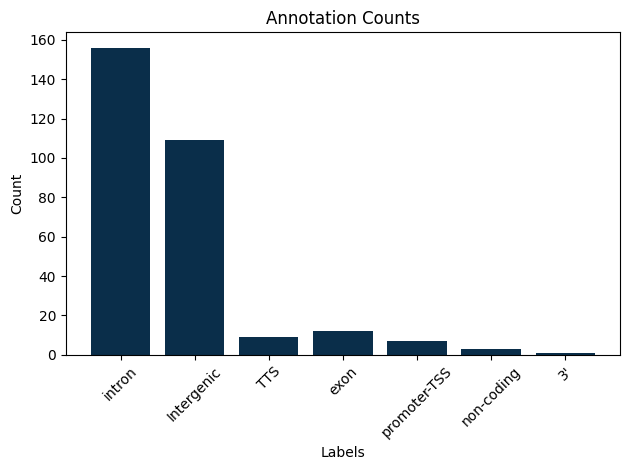

In [13]:
# characterize mapped regions with the annotatePeaks output
from collections import Counter

annotated_df = pd.read_csv("../output/bam_coverage_annotated_{}.txt".format("my_aln_sorted.filtered.bam"),sep="\t")

annotations = annotated_df.Annotation
annotations_list = []
for annot  in annotations:
    try:
        annotations_list.append(annot.split(" ")[0])
    except:
        print (f"{annot} can not be split")

annotations_set = Counter(annotations_list)

labels = list(annotations_set.keys())
values = list(annotations_set.values())

fig, ax = plt.subplots()
ax.bar(labels, values, color='#0a2e4aff')
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Annotation Counts')
plt.xticks(rotation=45)
plt.tight_layout()



I found the number of introns pretty high, but many times some reads spam through many regions, like:







In [34]:
# [----intron----][---exon----][--intron--]
# ---------+++++++++++++++++++++++---------

This would give 2 introns and an exon.

I could get the intersection of the gtf with the coverage and get the regions that get the most overlap, but it could be tricky, so I will just plot the histogram for the distance to nearest gene, this would give a good idea of the targeted areas.

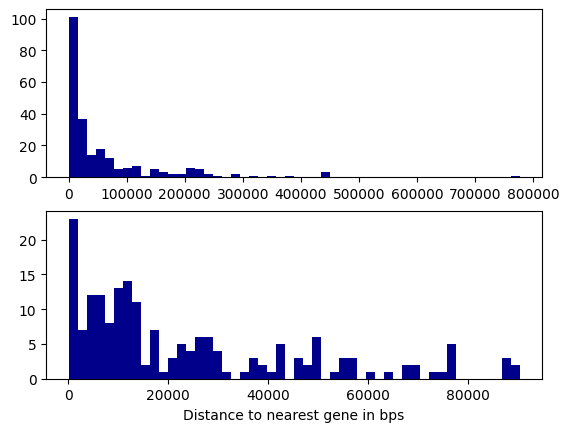

In [41]:
distances = annotated_df["Distance to TSS"].values.tolist()
distances = [np.abs(x) for x in distances]
distances_less_100K = [x for x in distances if x < 100000] # zoom in


fig, (ax1,ax2) = plt.subplots(2,1)
ax1.hist(distances,color="darkblue",bins=50)
ax2.hist(distances_less_100K,color="darkblue",bins=50)
ax2.set_xlabel("Distance to nearest gene in bps")
plt.show()



There are many that are very close to gene promoters. Still, some are far, which are likely to be intergenic.

In [14]:
# get gene names of reads falling in promoters, TSS and exons
annotated_df = annotated_df[annotated_df['Annotation'].notna()]
subset_labels = ["promoter","TSS","exon"]
subset_df = annotated_df[annotated_df['Annotation'].str.startswith(tuple(subset_labels))]
print (sorted(list(set(subset_df["Gene Name"]))))

['EGFR-AS1', 'GPR119', 'GPR37L1', 'KCNJ11', 'LILRB4', 'MCIDAS', 'MFAP2', 'MIR548O2', 'MIR8089', 'MT2A', 'PDZK1IP1', 'TLE2', 'TRPM3', 'TTPAL', 'UBASH3A', 'WDR97']


In [23]:
# get the genes where most reads are focused
median_reads_per_gene = overlapped_genes_df.groupby("name")["number_reads"].median()

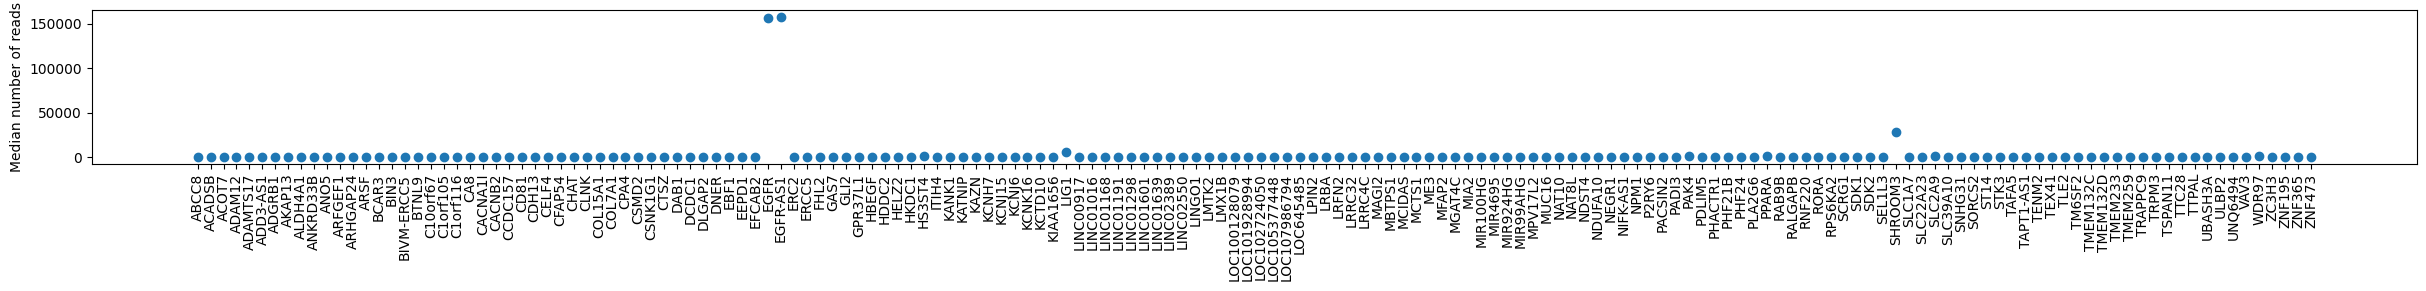

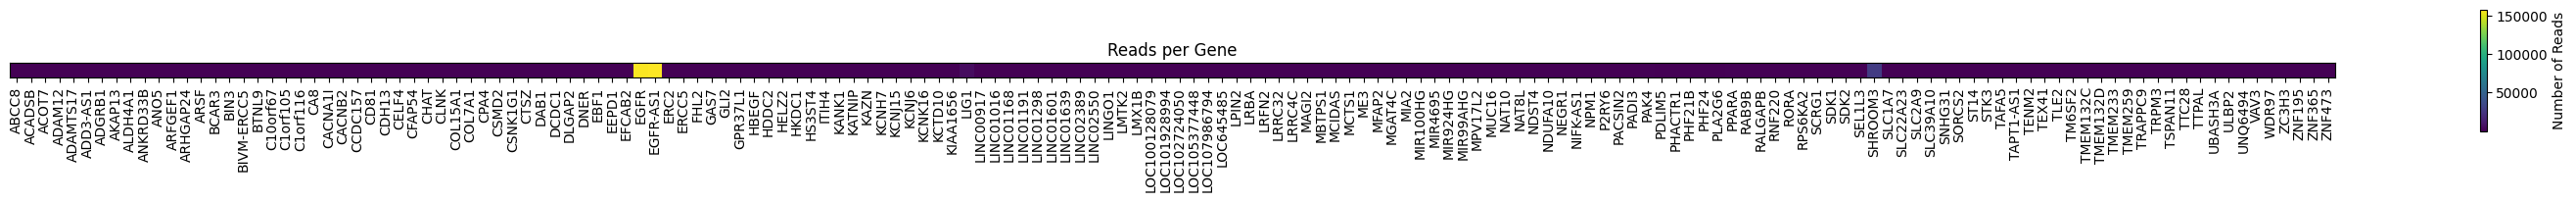

In [21]:
fig, ax = plt.subplots(figsize=(30,2))
ax.scatter(median_reads_per_gene.index, median_reads_per_gene.values)
plt.xticks(rotation=90)
plt.ylabel("Median number of reads")
plt.savefig("../output/manhattan_{}.pdf".format("my_aln_sorted.filtered"))
plt.show()

#values = np.array(df["number_reads"]).reshape(-1, 1)  # Reshape to vertical column
values = np.array(median_reads_per_gene.values).reshape(1,-1)
plt.figure(figsize=(30, 2))
plt.imshow(values, cmap="viridis")
plt.xticks(ticks=np.arange(len(median_reads_per_gene)), labels=median_reads_per_gene.index,rotation=90)
plt.yticks([])
plt.colorbar(label="Number of Reads")
plt.title("Reads per Gene")
plt.tight_layout()
plt.savefig("../output/heatmap_{}.pdf".format("my_aln_sorted.filtered"))
plt.show()

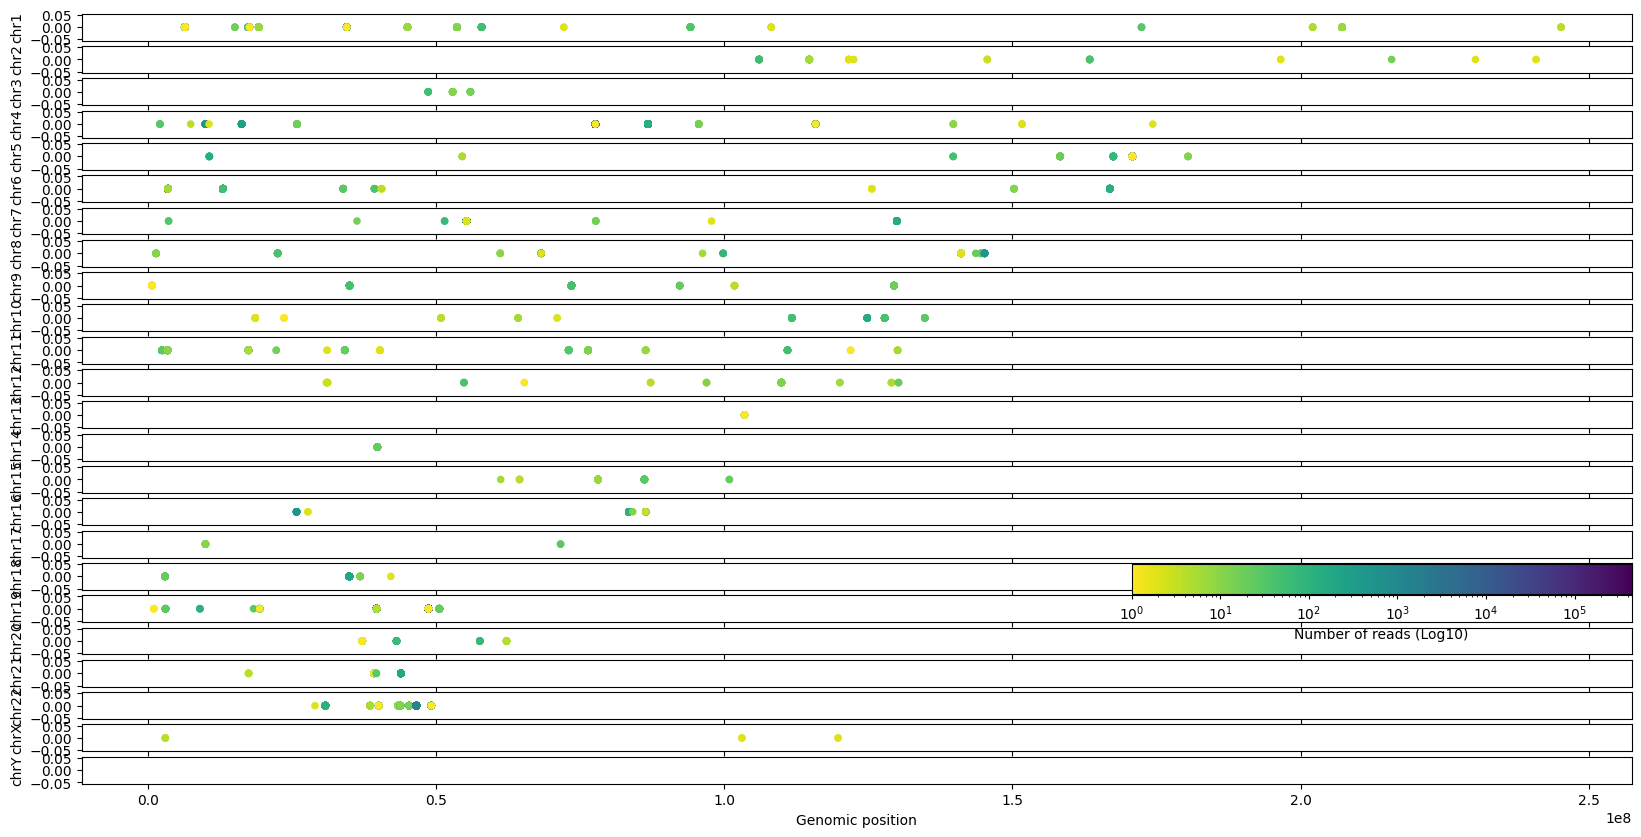

In [19]:
from matplotlib.colors import LogNorm

fig,axs = plt.subplots(24,1,figsize=(20,10),sharex=True,sharey=True)
all_chr = ["chr"+str(i) for i in range(1,23)]
all_chr.append("chrX")
all_chr.append("chrY")
n_reads = list(overlapped_genes_df["number_reads"])
vmax = max(overlapped_genes_df["number_reads"])
vmin = min(overlapped_genes_df["number_reads"])

for i, chr_ in enumerate(all_chr):
    subset_df = overlapped_genes_df.query("chrom1 == '{}'".format(chr_))
    scatter = axs[i].scatter(subset_df["start1"],np.zeros(len(subset_df)),cmap="viridis_r",c=subset_df["number_reads"],s=20,norm=LogNorm(vmin=vmin, vmax=vmax))
    axs[i].set_ylabel(chr_)
axs[i].set_xlabel("Genomic position")
cax = fig.add_axes([0.65, 0.3, 0.25, 0.03]) 
cbar = plt.colorbar(scatter,cax=cax,orientation='horizontal')
cbar.set_label('Number of reads (Log10)')

In [ ]:
# filter bam file for regions with a coverage depth of more than 5000 reads

covered = bamfile_bed.genome_coverage(bg=True)
df = covered.merge(c=4,o="median").to_dataframe()
high_coverage_df = df[df['name'] >= 5000]
high_coverage_df[['chrom', 'start', 'end']].to_csv("../output/{}.high_coverage.bed".format("my_aln_sorted.filtered"), sep="\t", header=False, index=False)
samtools_cmd("view", "-b", "-L", "../output/{}.high_coverage.bed".format("my_aln_sorted.filtered"), "../sequenceFile/{}".format("my_aln_sorted.filtered.bam"),_out= "../sequenceFile/{}.high_coverage.bam".format("my_aln_sorted.filtered"))
    

''

# TASK 2:  What variants/mutations can you identify in this data? How can you evaluate which variants are more “real” than others both from the technical and biological perspectives?

In [ ]:
## I need to index the genome
#samtools_cmd("faidx","../annotations/hg19.fa")

# I also need to rename the chromosome names in order to run the tools
#samtools_cmd("reheader","../sequenceFile/modified_header.txt","../sequenceFile/{}".format("my_aln_sorted.filtered.high_coverage.bam"),_out="../sequenceFile/{}.newheader.bam".format("my_aln_sorted.filtered.high_coverage"))
#samtools_cmd("index","../sequenceFile/{}.newheader.bam".format("my_aln_sorted.filtered.high_coverage"))

gatk_cmd = sh.Command("~/Downloads/gatk-4.6.1.0/gatk")

# run mutect2 to get somatic variants
try:
    gatk_cmd("CreateSequenceDictionary","-R","../annotations/hg19.fa","-O","../annotations/hg19.dict")
except:
    print ("hg19.dict already exists")
samtools_cmd("addreplacerg", "-r", "@RG\tID:samplename\tSM:samplename", "../sequenceFile/{}.bam".format("my_aln_sorted.filtered.high_coverage"), "-o" "../sequenceFile/{}.renamed.bam".format("my_aln_sorted.filtered.high_coverage"))
samtools_cmd("index", "../sequenceFile/{}.renamed.bam".format("my_aln_sorted.filtered.high_coverage"))
gatk_cmd("Mutect2","-R","../annotations/hg19.fa","-I","../sequenceFile/{}.renamed.bam".format("my_aln_sorted.filtered.high_coverage"),"-O","../output/mutect2_calling_{}.vcf.gz".format("my_aln_sorted.filtered.high_coverage.renamed"))


hg19.dict already exists


'Tool returned:\nSUCCESS\n'

In [54]:
# add common
gatk_cmd("FilterMutectCalls","-V","../output/mutect2_calling_{}.vcf.gz".format("my_aln_sorted.filtered.high_coverage.renamed"),"-R","../annotations/hg19.fa","-O", "../output/mutect2_calling_{}.vcf.gz".format("my_aln_sorted.filtered.high_coverage.renamed.passed"))

''

In [ ]:

# Not needed, FilterMutectCalls already applies these filters

header = ["CHROM","POS","ID","REF","ALT","QUAL","FILTER","INFO","FORMAT","samplename"]
skip_rows = 343
variants_df = pd.read_csv("../output/mutect2_calling_{}.vcf.gz".format("my_aln_sorted.filtered.high_coverage.renamed"),sep="\t",skiprows=skip_rows,names=header)

def calculate_VAF(row):
    ref_alt_values = row["samplename"].split(":")
    aux = ref_alt_values[1].split(",")
    ref = int(aux[0])
    alt = int(aux[1])
    return alt / (ref+alt) * 100

from scipy.stats import fisher_exact
def calculate_SB(row):
    sb_values = row["samplename"].split(":")
    aux = sb_values[-1].split(",")
    ref_fwd = int(aux[0])
    ref_rev = int(aux[1])
    alt_fwd = int(aux[2])
    alt_rev = int(aux[3])
    table = [[ref_fwd, ref_rev],
             [alt_fwd, alt_rev]]

    odds_ratio, p_value = fisher_exact(table)
    return p_value

def add_filter(row):
    if row["strand_bias_p_value"] <= 0.0005:
        return "PASS"
    
variants_df['variant_allele_freq'] = variants_df.apply(calculate_VAF,axis=1)
variants_df['strand_bias_p_value'] = variants_df.apply(calculate_SB,axis=1)
variants_df['FILTER'] = variants_df.apply(add_filter,axis=1)

print (variants_df)



    CHROM       POS ID               REF ALT QUAL FILTER  \
0    chr4  77620763  .                 C   T    .   None   
1    chr4  77620799  .                 A   G    .   None   
2    chr7  55241646  .                 T   C    .   PASS   
3    chr7  55242436  .                 G   C    .   None   
4    chr7  55242450  .                 T   C    .   PASS   
5    chr7  55242465  .  GGAATTAAGAGAAGCA   G    .   None   
6    chr7  55242509  .                 T   C    .   None   
7    chr7  55248963  .                 G   T    .   None   
8    chr7  55249063  .                 G   A    .   None   
9   chr19  48662851  .                 T   G    .   None   
10  chr19  48662905  .                 A   C    .   None   
11  chr19  48662907  .                 A   C    .   None   
12  chr19  48662913  .                 G   T    .   None   

                                                 INFO  \
0   AS_SB_TABLE=37,0|2,0;DP=39;ECNT=2;ECNTH=1;MBQ=...   
1   AS_SB_TABLE=134,1|6,0;DP=143;ECNT=2;ECNTH

In [ ]:

# run funconator to get relevance of the somatic variants.
# before, that we need to download all the databases/datasources to run against 

# run only once in another terminal, since it takes long time to download
# ~/Downloads/gatk-4.6.1.0/gatk FuncotatorDataSourceDownloader --somatic --validate-integrity --extract-after-download
# then:
# ~/Downloads/gatk-4.6.1.0/gatk --java-options "-DGATK_STACKTRACE_ON_USER_EXCEPTION=true" Funcotator --variant mutecy2_calling.vcf.gz --reference ../annotations/hg19.fa --ref-version hg19 --data-sources-path ../annotations/funcotator_dataSources.v1.8.hg19.20230908s --output variants.funconator.vcf --output-file-format VCF
gatk_cmd(
        "Funcotator",
        "--variant", "../output/mutect2_calling_{}.vcf.gz".format("my_aln_sorted.filtered.high_coverage.renamed.passed"),
        "--reference", "../annotations/hg19.fa",
        "--ref-version", "hg19",
        "--data-sources-path", "../annotations/funcotator_dataSources.v1.8.hg19.20230908s",
        "--output", "../output/variants.funconator_{}.vcf".format("my_aln_sorted.filtered.high_coverage.renamed.passed"),
        "--output-file-format", "VCF"
    )


'Tool returned:\ntrue\n'

In [ ]:
#transform the data for downstream analysis

import re

funcotator_fields = "Gencode_43_hugoSymbol|Gencode_43_ncbiBuild|Gencode_43_chromosome|Gencode_43_start|Gencode_43_end|Gencode_43_variantClassification|Gencode_43_secondaryVariantClassification|Gencode_43_variantType|Gencode_43_refAllele|Gencode_43_tumorSeqAllele1|Gencode_43_tumorSeqAllele2|Gencode_43_genomeChange|Gencode_43_annotationTranscript|Gencode_43_transcriptStrand|Gencode_43_transcriptExon|Gencode_43_transcriptPos|Gencode_43_cDnaChange|Gencode_43_codonChange|Gencode_43_proteinChange|Gencode_43_gcContent|Gencode_43_referenceContext|Gencode_43_otherTranscripts|Achilles_Top_Genes|CGC_Name|CGC_GeneID|CGC_Chr|CGC_Chr_Band|CGC_Cancer_Somatic_Mut|CGC_Cancer_Germline_Mut|CGC_Tumour_Types__(Somatic_Mutations)|CGC_Tumour_Types_(Germline_Mutations)|CGC_Cancer_Syndrome|CGC_Tissue_Type|CGC_Cancer_Molecular_Genetics|CGC_Mutation_Type|CGC_Translocation_Partner|CGC_Other_Germline_Mut|CGC_Other_Syndrome/Disease|ClinVar_HGMD_ID|ClinVar_SYM|ClinVar_TYPE|ClinVar_ASSEMBLY|ClinVar_rs|ClinVar_VCF_AF_ESP|ClinVar_VCF_AF_EXAC|ClinVar_VCF_AF_TGP|ClinVar_VCF_ALLELEID|ClinVar_VCF_CLNDISDB|ClinVar_VCF_CLNDISDBINCL|ClinVar_VCF_CLNDN|ClinVar_VCF_CLNDNINCL|ClinVar_VCF_CLNHGVS|ClinVar_VCF_CLNREVSTAT|ClinVar_VCF_CLNSIG|ClinVar_VCF_CLNSIGCONF|ClinVar_VCF_CLNSIGINCL|ClinVar_VCF_CLNVC|ClinVar_VCF_CLNVCSO|ClinVar_VCF_CLNVI|ClinVar_VCF_DBVARID|ClinVar_VCF_GENEINFO|ClinVar_VCF_MC|ClinVar_VCF_ORIGIN|ClinVar_VCF_RS|ClinVar_VCF_ID|ClinVar_VCF_FILTER|Cosmic_overlapping_mutations|CosmicFusion_fusion_genes|CosmicFusion_fusion_id|CosmicTissue_total_alterations_in_gene|CosmicTissue_tissue_types_affected|DNARepairGenes_Activity_linked_to_OMIM|DNARepairGenes_Chromosome_location_linked_to_Genome_Data_Viewer|DNARepairGenes_Accession_number_linked_to_NCBI_Entrez|Familial_Cancer_Genes_Syndrome|Familial_Cancer_Genes_Synonym|Familial_Cancer_Genes_Reference|Gencode_XHGNC_hgnc_id|Gencode_XRefSeq_mRNA_id|Gencode_XRefSeq_prot_acc|HGNC_HGNC_ID|HGNC_Approved_name|HGNC_Status|HGNC_Locus_type|HGNC_Locus_group|HGNC_Previous_symbols|HGNC_Previous_name|HGNC_Alias_symbols|HGNC_Alias_names|HGNC_Chromosome|HGNC_Date_modified|HGNC_Date_symbol_changed|HGNC_Date_name_changed|HGNC_Accession_numbers|HGNC_Enzyme_IDs|HGNC_NCBI_Gene_ID|HGNC_Ensembl_gene_ID|HGNC_Pubmed_IDs|HGNC_RefSeq_IDs|HGNC_Gene_group_ID|HGNC_Gene_group_name|HGNC_CCDS_IDs|HGNC_Vega_IDs|HGNC_NCBI_Gene_ID(supplied_by_NCBI)|HGNC_OMIM_ID(supplied_by_OMIM)|HGNC_RefSeq(supplied_by_NCBI)|HGNC_UniProt_ID(supplied_by_UniProt)|HGNC_Ensembl_ID(supplied_by_Ensembl)|HGNC_UCSC_ID(supplied_by_UCSC)|Oreganno_Build|Oreganno_ID|Oreganno_Values|Simple_Uniprot_uniprot_entry_name|Simple_Uniprot_DrugBank|Simple_Uniprot_alt_uniprot_accessions|Simple_Uniprot_uniprot_accession|Simple_Uniprot_GO_Biological_Process|Simple_Uniprot_GO_Cellular_Component|Simple_Uniprot_GO_Molecular_Function|dbSNP_ASP|dbSNP_ASS|dbSNP_CAF|dbSNP_CDA|dbSNP_CFL|dbSNP_COMMON|dbSNP_DSS|dbSNP_G5|dbSNP_G5A|dbSNP_GENEINFO|dbSNP_GNO|dbSNP_HD|dbSNP_INT|dbSNP_KGPhase1|dbSNP_KGPhase3|dbSNP_LSD|dbSNP_MTP|dbSNP_MUT|dbSNP_NOC|dbSNP_NOV|dbSNP_NSF|dbSNP_NSM|dbSNP_NSN|dbSNP_OM|dbSNP_OTH|dbSNP_PM|dbSNP_PMC|dbSNP_R3|dbSNP_R5|dbSNP_REF|dbSNP_RS|dbSNP_RSPOS|dbSNP_RV|dbSNP_S3D|dbSNP_SAO|dbSNP_SLO|dbSNP_SSR|dbSNP_SYN|dbSNP_TOPMED|dbSNP_TPA|dbSNP_U3|dbSNP_U5|dbSNP_VC|dbSNP_VLD|dbSNP_VP|dbSNP_WGT|dbSNP_WTD|dbSNP_dbSNPBuildID|dbSNP_ID|dbSNP_FILTER|gnomAD_exome_AF|gnomAD_exome_AF_afr|gnomAD_exome_AF_afr_female|gnomAD_exome_AF_afr_male|gnomAD_exome_AF_amr|gnomAD_exome_AF_amr_female|gnomAD_exome_AF_amr_male|gnomAD_exome_AF_asj|gnomAD_exome_AF_asj_female|gnomAD_exome_AF_asj_male|gnomAD_exome_AF_eas|gnomAD_exome_AF_eas_female|gnomAD_exome_AF_eas_jpn|gnomAD_exome_AF_eas_kor|gnomAD_exome_AF_eas_male|gnomAD_exome_AF_eas_oea|gnomAD_exome_AF_female|gnomAD_exome_AF_fin|gnomAD_exome_AF_fin_female|gnomAD_exome_AF_fin_male|gnomAD_exome_AF_male|gnomAD_exome_AF_nfe|gnomAD_exome_AF_nfe_bgr|gnomAD_exome_AF_nfe_est|gnomAD_exome_AF_nfe_female|gnomAD_exome_AF_nfe_male|gnomAD_exome_AF_nfe_nwe|gnomAD_exome_AF_nfe_onf|gnomAD_exome_AF_nfe_seu|gnomAD_exome_AF_nfe_swe|gnomAD_exome_AF_oth|gnomAD_exome_AF_oth_female|gnomAD_exome_AF_oth_male|gnomAD_exome_AF_popmax|gnomAD_exome_AF_raw|gnomAD_exome_AF_sas|gnomAD_exome_AF_sas_female|gnomAD_exome_AF_sas_male|gnomAD_exome_ID|gnomAD_exome_FILTER|gnomAD_genome_AF|gnomAD_genome_AF_afr|gnomAD_genome_AF_afr_female|gnomAD_genome_AF_afr_male|gnomAD_genome_AF_amr|gnomAD_genome_AF_amr_female|gnomAD_genome_AF_amr_male|gnomAD_genome_AF_asj|gnomAD_genome_AF_asj_female|gnomAD_genome_AF_asj_male|gnomAD_genome_AF_eas|gnomAD_genome_AF_eas_female|gnomAD_genome_AF_eas_male|gnomAD_genome_AF_female|gnomAD_genome_AF_fin|gnomAD_genome_AF_fin_female|gnomAD_genome_AF_fin_male|gnomAD_genome_AF_male|gnomAD_genome_AF_nfe|gnomAD_genome_AF_nfe_est|gnomAD_genome_AF_nfe_female|gnomAD_genome_AF_nfe_male|gnomAD_genome_AF_nfe_nwe|gnomAD_genome_AF_nfe_onf|gnomAD_genome_AF_nfe_seu|gnomAD_genome_AF_oth|gnomAD_genome_AF_oth_female|gnomAD_genome_AF_oth_male|gnomAD_genome_AF_popmax|gnomAD_genome_AF_raw|gnomAD_genome_ID|gnomAD_genome_FILTER"
header = ["CHROM","POS","ID","REF","ALT","QUAL","FILTER","INFO","FORMAT","S1"]
skip_rows = 372
func_df = pd.read_csv( "../output/variants.funconator_{}.vcf".format("my_aln_sorted.filtered.high_coverage.renamed.passed"),sep="\t",skiprows=skip_rows,names=header)
subset_df = func_df[header[:-3]].copy()

subset_df['FUNCOTATOR'] = func_df['INFO'].str.extract(r'FUNCOTATION=\[(.*)\];GERMQ')
subset_df['FUNC_AUX'] = subset_df['FUNCOTATOR'].str.split(",")
subset_df['FUNC_PRIMARY'] = subset_df['FUNC_AUX'].str[0]
func_cols_df = subset_df["FUNC_PRIMARY"].str.split(r'\|', expand=True)
final_df = pd.concat([subset_df[header[:-3]], func_cols_df], axis=1)
header2 = funcotator_fields.split("|")
header1 = header[:-3]
final_header = header1+header2
final_df.columns = final_header
final_df.to_csv("../output/final_mutation_list.tsv",sep="\t")


(13, 10)
(13, 241)


In [ ]:
# Now, get some examples of diseases driving mutations

final_df["gnomAD_exome_AF"] = pd.to_numeric(final_df["gnomAD_exome_AF"],errors="coerce").astype(float)

filtered_mutations_df = final_df.query(
    "`CGC_Tumour_Types__(Somatic_Mutations)` != '' or \
    `ClinVar_rs` != '' or \
    `gnomAD_exome_AF` <= 1 or \
    `Cosmic_overlapping_mutations` != ''"
)

filtered_mutations_df.to_csv("../output/final_filtered_mutations.tsv",sep="\t")

In [ ]:

# In case I want to use bcftools

# run bcftools to call variants
~/Downloads/bcftools/bcftools mpileup -Ou -f ../annotations/hg19.fa aln.bam | ~/Downloads/bcftools/bcftools call -mv -Ob -o variants.raw.bcf

# make it readable
~/Downloads/bcftools/bcftools view variants.raw.bcf > variants.vcf

# inspect the vcf file and check some of the variants:
samtools tview aln_newheader.bam hg19.fa -p chr11:34133534

# I can filter for the variants quality
# followed these recomendations
https://www.htslib.org/workflow/filter.html

    
~/Downloads/bcftools/bcftools view -e 'QUAL <= 10 || DP < 10 || DP > 300 || MQBZ < -10 || RPBZ < -5 || RPBZ > 5 || MQSBZ > 100 || SCBZ > 4' -Ov -o good_quality_variants.vcf variants.vcf


In [ ]:
# bcftools has a tool that takes the relevant SNVs 
~/Downloads/bcftools/bcftools csq --unify-chr-names "chr,-,chr" -f hg19.fa -g Homo_sapiens.GRCh38.113.gff3 ../sequenceFile/good_quality_variants.vcf -Ob -o good_quality_variants_csq.bcf